### Compare multiple CNN architectures under controlled conditions and study generalization.

In [75]:
import pandas as pd

In [76]:
df_train = pd.read_csv('dataset/mnist_train.csv')
df_test = pd.read_csv('dataset/mnist_test.csv')


In [77]:
print(df_train.shape)
print(df_test.shape)

(59999, 785)
(9999, 785)


In [78]:
df_train.head()

,5,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
df_test.head()

,7,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.658,0.659,0.660,0.661,0.662,0.663,0.664,0.665,0.666,0.667
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
df_test.shape

(9999, 785)

In [81]:
train_labels = df_train.iloc[:, 0].values        # first column
train_images = df_train.iloc[:, 1:].values       # remaining 784 columns


test_labels = df_test.iloc[:, 0].values
test_images = df_test.iloc[:, 1:].values

In [82]:
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images,
    train_labels,
    test_size=0.2,
    random_state=42,
    stratify=train_labels
)

In [83]:
import torch

# Step 3: convert to torch ONCE

train_images = torch.tensor(train_images)
train_labels = torch.tensor(train_labels, dtype=torch.long)

val_images = torch.tensor(val_images)
val_labels = torch.tensor(val_labels, dtype=torch.long)

test_images = torch.tensor(test_images)
test_labels = torch.tensor(test_labels, dtype=torch.long)


In [84]:
test_images.shape

torch.Size([9999, 784])

In [85]:
# Step 4: reshape + normalize
train_images = train_images.reshape(-1, 1, 28, 28).float() / 255.0
val_images = val_images.reshape(-1,1,28,28).float()/255.0
test_images  = test_images.reshape(-1, 1, 28, 28).float() / 255.0


In [86]:
print("images shape:", train_images.shape)
print("labels shape:", train_labels.shape)

print("images shape:", val_images.shape)
print("labels shape:", val_labels.shape)

print("images shape:", test_images.shape)
print("labels shape:", test_labels.shape)


images shape: torch.Size([47999, 1, 28, 28])
labels shape: torch.Size([47999])
images shape: torch.Size([12000, 1, 28, 28])
labels shape: torch.Size([12000])
images shape: torch.Size([9999, 1, 28, 28])
labels shape: torch.Size([9999])


In [87]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_images,train_labels)
test_dataset = TensorDataset(test_images,test_labels)
val_dataset = TensorDataset(val_images,val_labels)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False
)

In [88]:
import torch.nn as nn 
import torch.optim as optim
from tqdm import tqdm


In [89]:
#simple cnn level 1:
class cnn_l1(nn.Module):
    def __init__(self):
        super(cnn_l1, self).__init__()

        self.conv = nn.Conv2d(1,8,kernel_size=3)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(8*26*26,10)

    def forward(self, x):
        x = self.relu(self.conv(x))
        x = x.view(x.size(0),-1)
        return self.fc(x)

In [90]:
#level 2:
class cnn_l2(nn.Module):
    def __init__(self):
        super(cnn_l2,self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16,32,3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Linear(32*7*7,10)

    def forward(self, x):
        x = self.features(x)
        # Convert 4D CNN output into 2D so it can be passed to nn.Linear
        x = x.view(x.size(0), -1) 
        return self.classifier(x)

In [91]:
# level 3:
class cnn_l3(nn.Module):
    def __init__(self):
        super(cnn_l3, self).__init__()

        self.feature = nn.Sequential(
            nn.Conv2d(1,32,3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32,64,3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*7*7,128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128,10)
        )

    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [92]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#model builder

def build_model(model):
    model = model().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    return model, criterion, optimizer

Using device: cuda


In [ ]:
#training loop
def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(loader):
        images,labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(loader)

In [94]:
def eval_c(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy


In [102]:
import matplotlib.pyplot as plt

def plot_g(train, val, model_name):
    epochs_range = range(1, len(train) + 1)

    plt.figure()
    plt.plot(epochs_range, train, label="Train Loss")
    plt.title(f"{model_name} - Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(epochs_range, val, label="Val Accuracy")
    plt.title(f"{model_name} - Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()



Training cnn_l1


  2%|▏         | 30/1500 [00:00<00:04, 299.11it/s]

100%|██████████| 1500/1500 [00:03<00:00, 431.13it/s]


Epoch 1 | Train Loss: 0.3017 | Val Acc: 0.9532


100%|██████████| 1500/1500 [00:01<00:00, 765.08it/s]


Epoch 2 | Train Loss: 0.1242 | Val Acc: 0.9694


100%|██████████| 1500/1500 [00:03<00:00, 442.82it/s]


Epoch 3 | Train Loss: 0.0807 | Val Acc: 0.9703


100%|██████████| 1500/1500 [00:03<00:00, 446.41it/s]


Epoch 4 | Train Loss: 0.0615 | Val Acc: 0.9765


100%|██████████| 1500/1500 [00:02<00:00, 500.20it/s]


Epoch 5 | Train Loss: 0.0486 | Val Acc: 0.9754


100%|██████████| 1500/1500 [00:03<00:00, 479.39it/s]


Epoch 6 | Train Loss: 0.0389 | Val Acc: 0.9775


100%|██████████| 1500/1500 [00:02<00:00, 503.43it/s]


Epoch 7 | Train Loss: 0.0327 | Val Acc: 0.9774


100%|██████████| 1500/1500 [00:03<00:00, 493.63it/s]


Epoch 8 | Train Loss: 0.0273 | Val Acc: 0.9780


100%|██████████| 1500/1500 [00:02<00:00, 627.91it/s]


Epoch 9 | Train Loss: 0.0223 | Val Acc: 0.9791


100%|██████████| 1500/1500 [00:02<00:00, 598.57it/s]


Epoch 10 | Train Loss: 0.0188 | Val Acc: 0.9776
Test Accuracy for cnn_l1: 0.9768


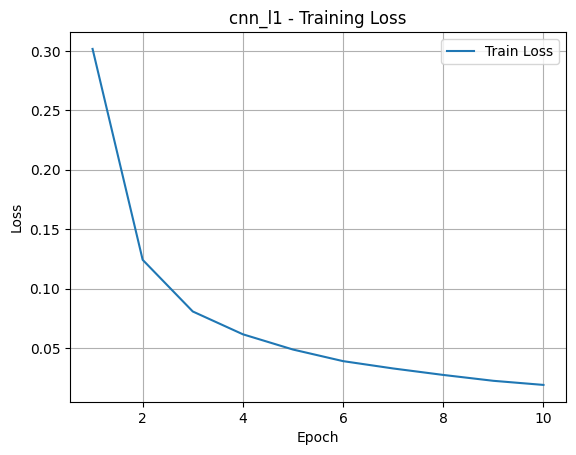

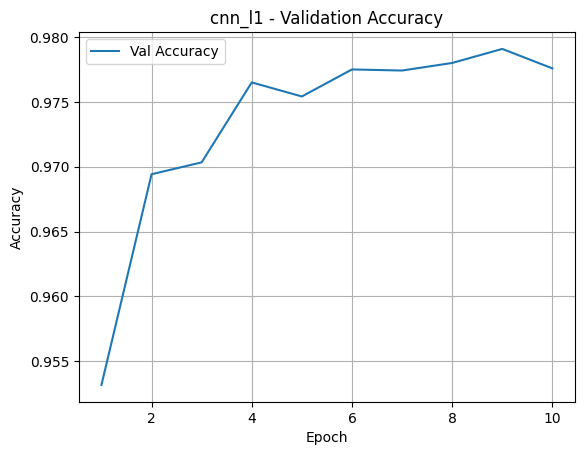


Training cnn_l2


100%|██████████| 1500/1500 [00:04<00:00, 361.01it/s]


Epoch 1 | Train Loss: 0.2110 | Val Acc: 0.9696


100%|██████████| 1500/1500 [00:03<00:00, 445.75it/s]


Epoch 2 | Train Loss: 0.0665 | Val Acc: 0.9764


100%|██████████| 1500/1500 [00:03<00:00, 376.31it/s]


Epoch 3 | Train Loss: 0.0493 | Val Acc: 0.9814


100%|██████████| 1500/1500 [00:03<00:00, 423.83it/s]


Epoch 4 | Train Loss: 0.0389 | Val Acc: 0.9853


100%|██████████| 1500/1500 [00:03<00:00, 460.38it/s]


Epoch 5 | Train Loss: 0.0311 | Val Acc: 0.9814


100%|██████████| 1500/1500 [00:04<00:00, 351.03it/s]


Epoch 6 | Train Loss: 0.0264 | Val Acc: 0.9864


100%|██████████| 1500/1500 [00:02<00:00, 649.48it/s]


Epoch 7 | Train Loss: 0.0219 | Val Acc: 0.9855


100%|██████████| 1500/1500 [00:03<00:00, 445.45it/s]


Epoch 8 | Train Loss: 0.0196 | Val Acc: 0.9860


100%|██████████| 1500/1500 [00:03<00:00, 431.27it/s]


Epoch 9 | Train Loss: 0.0161 | Val Acc: 0.9854


100%|██████████| 1500/1500 [00:02<00:00, 676.63it/s]


Epoch 10 | Train Loss: 0.0128 | Val Acc: 0.9855
Test Accuracy for cnn_l2: 0.9882


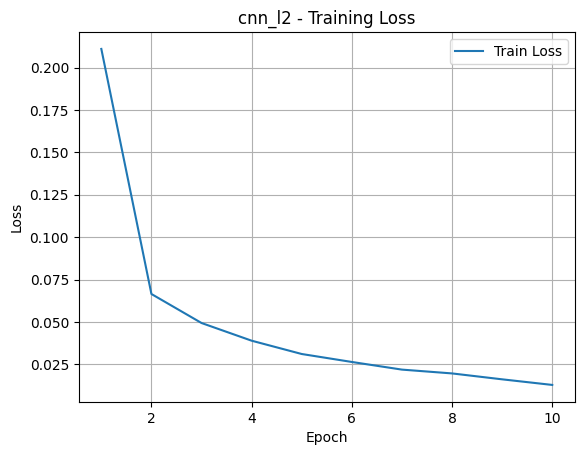

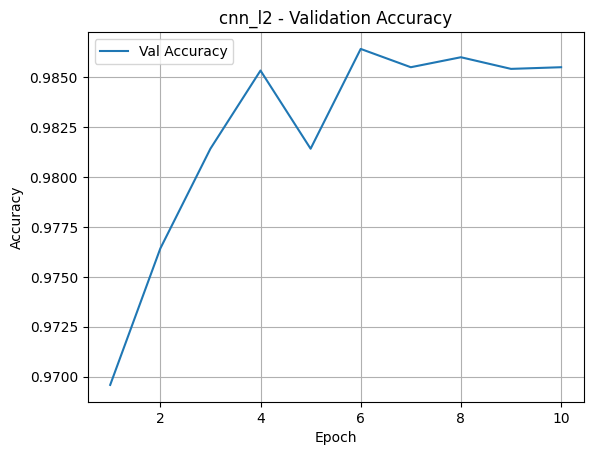


Training cnn_l3


100%|██████████| 1500/1500 [00:03<00:00, 443.72it/s]


Epoch 1 | Train Loss: 0.2754 | Val Acc: 0.9824


100%|██████████| 1500/1500 [00:03<00:00, 467.78it/s]


Epoch 2 | Train Loss: 0.1357 | Val Acc: 0.9818


100%|██████████| 1500/1500 [00:03<00:00, 417.25it/s]


Epoch 3 | Train Loss: 0.1030 | Val Acc: 0.9862


100%|██████████| 1500/1500 [00:05<00:00, 295.48it/s]


Epoch 4 | Train Loss: 0.0855 | Val Acc: 0.9863


100%|██████████| 1500/1500 [00:03<00:00, 405.05it/s]


Epoch 5 | Train Loss: 0.0754 | Val Acc: 0.9892


100%|██████████| 1500/1500 [00:04<00:00, 315.85it/s]


Epoch 6 | Train Loss: 0.0660 | Val Acc: 0.9896


100%|██████████| 1500/1500 [00:05<00:00, 282.07it/s]


Epoch 7 | Train Loss: 0.0556 | Val Acc: 0.9892


100%|██████████| 1500/1500 [00:05<00:00, 297.30it/s]


Epoch 8 | Train Loss: 0.0507 | Val Acc: 0.9901


100%|██████████| 1500/1500 [00:04<00:00, 328.93it/s]


Epoch 9 | Train Loss: 0.0467 | Val Acc: 0.9911


100%|██████████| 1500/1500 [00:04<00:00, 354.66it/s]


Epoch 10 | Train Loss: 0.0417 | Val Acc: 0.9890
Test Accuracy for cnn_l3: 0.9922


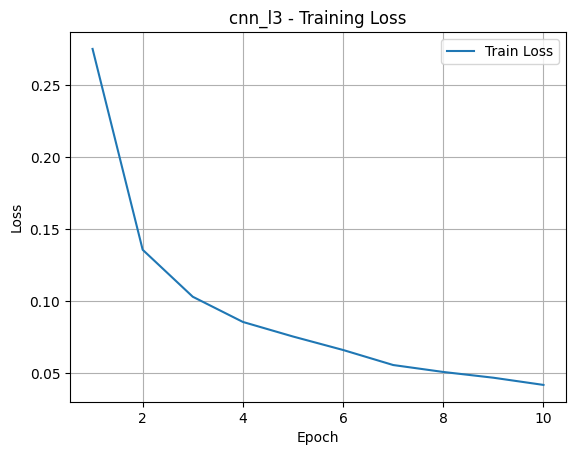

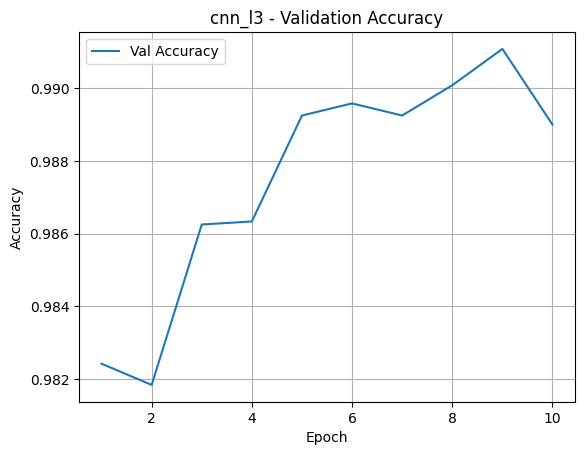

In [103]:
models = [cnn_l1, cnn_l2, cnn_l3]

epochs = 10  


for model_class in models:
    print(f"\nTraining {model_class.__name__}")
    model, criterion, optimizer = build_model(model_class)

    history_val = []
    history_train = []

    for epoch in range(epochs):
        loss = train(model, train_loader, criterion, optimizer)
        val_acc = eval_c(model, val_loader)
        print(
            f"Epoch {epoch+1} | "
            f"Train Loss: {loss:.4f} | "
            f"Val Acc: {val_acc:.4f}"
        )
        history_val.append(val_acc)
        history_train.append(loss)

    acc = eval_c(model, test_loader)
    # IMPORTANT: eval() must be called on the TRAINED MODEL INSTANCE, not the class
    print(f"Test Accuracy for {model_class.__name__}: {acc:.4f}")
    plot_g(history_train,history_val, model_class.__name__)
    